# Import Libraries

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
from matplotlib.patches import Rectangle

# Access MOANA rasters

In [3]:
auth = earthaccess.login()

In [4]:
tspan = ("2024-04-01", "2025-08-31")

In [5]:
results_moana = earthaccess.search_data(
    short_name="PACE_OCI_L3M_MOANA",
    granule_name="*.Day.*0p1deg*",  # Daily: Day | Resolution: 0p1deg or 4 (for 4km)
    temporal=tspan,
)

In [6]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable
    Args:
        ds: a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    return ds

In [7]:
path_files = earthaccess.open(results_moana)

QUEUEING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/376 [00:00<?, ?it/s]

In [8]:
dataset_moana = xr.open_mfdataset(
    path_files, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset_moana

<xarray.Dataset> Size: 7GB
Dimensions:          (date: 376, lat: 1400, lon: 1100, rgb: 3,
                      eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 6kB 69.95 69.85 69.75 ... -69.85 -69.95
  * lon              (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.85 24.95
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (date, rgb, eightbitcolor) uint8 289kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         166600
    data_minimum:                      -inf
    data_maximum:                      inf

## Clean data

In [9]:
dataset_moana["prococcus_moana"] = dataset_moana["prococcus_moana"].clip(
    min=dataset_moana["prococcus_moana"].attrs["valid_min"],
    max=dataset_moana["prococcus_moana"].attrs["valid_max"],
)
dataset_moana["syncoccus_moana"] = dataset_moana["syncoccus_moana"].clip(
    min=dataset_moana["syncoccus_moana"].attrs["valid_min"],
    max=dataset_moana["syncoccus_moana"].attrs["valid_max"],
)
dataset_moana["picoeuk_moana"] = dataset_moana["picoeuk_moana"].clip(
    min=dataset_moana["picoeuk_moana"].attrs["valid_min"],
    max=dataset_moana["picoeuk_moana"].attrs["valid_max"],
)

In [10]:
dataset_phy = dataset_moana.drop_vars(["palette"])

# Access Lat/Lon of AMT Transect

In [14]:
# Load and deduplicate lat/lon points
points_df = pd.read_csv("AMT28_underway_latlon.csv").drop_duplicates(subset=["Lat", "Lon"]).reset_index(drop=True)
points_df["point"] = np.arange(len(points_df))

# Create point-indexed lat/lon DataArrays
lat_da = xr.DataArray(points_df["Lat"].values, dims="point")
lon_da = xr.DataArray(points_df["Lon"].values, dims="point")

In [ ]:
points_df.head()

# Monthly Stats Extraction

## Reduce raster stack to monthly composites

In [ ]:
# Compute monthly stats
mean_ds = dataset_phy.resample(date="1M").mean("date")
median_ds = dataset_phy.resample(date="1M").median("date")
std_ds = dataset_phy.resample(date="1M").std("date")
count_ds = dataset_phy.resample(date="1M").count("date")

# Compute CV 
cv_ds = std_ds / mean_ds

## Normalize

In [29]:
def normalize_phy_dataset(ds, variables=None):
    ds = ds.astype(np.float64)
    
    # Min-max normalization
    norm = (ds - ds.min()) / (ds.max() - ds.min())
    
    # Convert to DataArray (stacked along 'variable' dim)
    data_norm = norm.to_array("variable")

    # filter variables
    if variables is not None:
        data_norm = data_norm.sel(variable=variables)
    
    return data_norm

In [30]:
# Normalize each
mean_norm = normalize_phy_dataset(mean_ds)
median_norm = normalize_phy_dataset(median_ds)
std_norm = normalize_phy_dataset(std_ds)
cv_norm = normalize_phy_dataset(cv_ds)


## Extract stats from AMT transect for normalized and unnormalized data

In [ ]:
# unnormalized
mean_da   = mean_ds.to_array("variable")
median_da = median_ds.to_array("variable")
std_da    = std_ds.to_array("variable")
cv_da     = cv_ds.to_array("variable")

unnorm_layers = {
    "mean": mean_da,
    "median": median_da,
    "std": std_da,
    "cv": cv_da,
}

In [81]:
# normalized
norm_layers = {
    "mean": mean_norm,
    "median": median_norm,
    "std": std_norm,
    "cv": cv_norm,
}

In [ ]:
# List of shared stats
stat_names = list(norm_layers.keys())

In [82]:
def extract_group(group_name, norm_layers, lat_da, lon_da, points_df):
    """
    Extract all stats for one phytoplankton group using nearest-neighbor selection.
    Returns a long-form DataFrame.
    """
    records = []
    
    for stat_name, da_stat in norm_layers.items():
        print(f"Extracting {group_name} - {stat_name}")
        
        da = da_stat.sel(variable=group_name)

        # Vectorized nearest-neighbor selection across (date, point)
        interp = da.sel(lat=lat_da, lon=lon_da, method="nearest").compute()

        # Result dims: (date, point) → convert to long-form
        df = interp.to_dataframe(name="value").reset_index()

        # Merge back lat/lon
        df = df.merge(points_df, on="point")[["date", "Lat", "Lon", "value"]]
        df["stat"] = stat_name
        df["variable"] = group_name

        records.append(df)

    return pd.concat(records, ignore_index=True)


In [84]:
#Extract unnormalized data
df_syncoccus = extract_group("syncoccus_moana", unnorm_layers, lat_da, lon_da, points_df)
df_picoeuk = extract_group("picoeuk_moana", unnorm_layers, lat_da, lon_da, points_df)
df_prococcus = extract_group("prococcus_moana", unnorm_layers, lat_da, lon_da, points_df)

Extracting syncoccus_moana - mean
Extracting syncoccus_moana - median
Extracting syncoccus_moana - std
Extracting syncoccus_moana - cv
Extracting picoeuk_moana - mean
Extracting picoeuk_moana - median
Extracting picoeuk_moana - std
Extracting picoeuk_moana - cv
Extracting prococcus_moana - mean
Extracting prococcus_moana - median
Extracting prococcus_moana - std
Extracting prococcus_moana - cv


In [85]:
#Extract normalized data
df_syncoccus_norm = extract_group("syncoccus_moana", norm_layers, lat_da, lon_da, points_df)
df_picoeuk_norm   = extract_group("picoeuk_moana", norm_layers, lat_da, lon_da, points_df)
df_prococcus_norm = extract_group("prococcus_moana", norm_layers, lat_da, lon_da, points_df)

Extracting syncoccus_moana - mean
Extracting syncoccus_moana - median
Extracting syncoccus_moana - std
Extracting syncoccus_moana - cv
Extracting picoeuk_moana - mean
Extracting picoeuk_moana - median
Extracting picoeuk_moana - std
Extracting picoeuk_moana - cv
Extracting prococcus_moana - mean
Extracting prococcus_moana - median
Extracting prococcus_moana - std
Extracting prococcus_moana - cv


## Organize tables

### Unnormalized

In [86]:
# Add month-year label for plotting
df_syncoccus["date"] = df_syncoccus["date"].dt.strftime("%b %Y")
df_picoeuk["date"] = df_picoeuk["date"].dt.strftime("%b %Y")
df_prococcus["date"] = df_prococcus["date"].dt.strftime("%b %Y")

# Rename column
df_syncoccus.rename(columns={'date': 'month_year'}, inplace=True)
df_picoeuk.rename(columns={'date': 'month_year'}, inplace=True)
df_prococcus.rename(columns={'date': 'month_year'}, inplace=True)

In [87]:
# Pivot to picoeuk wide format
df_picoeuk_wide = df_picoeuk.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_picoeuk_wide["value"] = "picoeuk"

In [88]:
# Pivot to pro wide format
df_pro_wide = df_prococcus.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_pro_wide["value"] = "prococcus"

In [89]:
# Pivot to syn wide format
df_syn_wide = df_syncoccus.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_syn_wide["value"] = "syncoccus"

### Normalized

In [90]:
# Add month-year label for plotting
df_syncoccus_norm["date"] = df_syncoccus_norm["date"].dt.strftime("%b %Y")
df_picoeuk_norm["date"] = df_picoeuk_norm["date"].dt.strftime("%b %Y")
df_prococcus_norm["date"] = df_prococcus_norm["date"].dt.strftime("%b %Y")

# Rename column
df_syncoccus_norm.rename(columns={'date': 'month_year'}, inplace=True)
df_picoeuk_norm.rename(columns={'date': 'month_year'}, inplace=True)
df_prococcus_norm.rename(columns={'date': 'month_year'}, inplace=True)

In [91]:
# Pivot to picoeuk wide format
df_picoeuk_wide_norm = df_picoeuk_norm.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_picoeuk_wide_norm["value"] = "picoeuk"

In [92]:
# Pivot to pro wide format
df_pro_wide_norm = df_prococcus_norm.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_pro_wide_norm["value"] = "prococcus"

In [93]:
# Pivot to syn wide format
df_syn_wide_norm = df_syncoccus_norm.pivot_table(
    index=["month_year", "Lat", "Lon"],
    columns="stat",
    values="value"
).reset_index()

df_syn_wide_norm["value"] = "syncoccus"

## Export

In [94]:
df_picoeuk_wide.to_csv("Tables/picoeuk_monthly_stats_unnormalized.csv", index=False)
df_pro_wide.to_csv("Tables/prococcus_monthly_stats_unnormalized.csv", index=False)
df_syn_wide.to_csv("Tables/syncoccus_monthly_stats_unnormalized.csv", index=False)

In [95]:
df_picoeuk_wide_norm.to_csv("Tables/picoeuk_monthly_stats_normalized.csv", index=False)
df_pro_wide_norm.to_csv("Tables/prococcus_monthly_stats_normalized.csv", index=False)
df_syn_wide_norm.to_csv("Tables/syncoccus_monthly_stats_normalized.csv", index=False)

# Figures

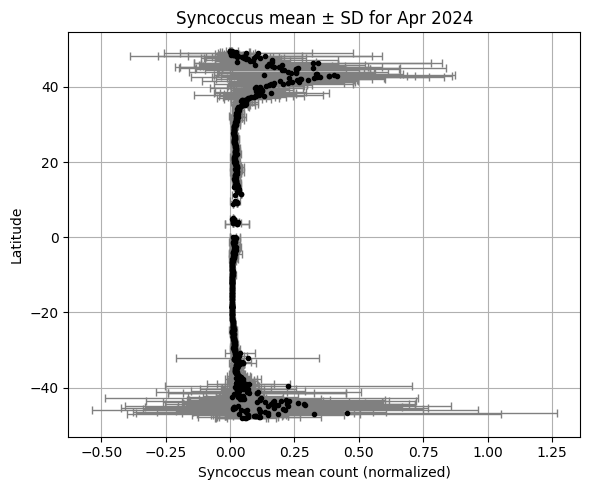

In [57]:
# Define month to plot
target_date = "Apr 2024"

# Filter for that month
plot_syn = df_syn_wide[df_syn_wide["month_year"] == target_date]

# Plot mean ± std as horizontal error bars
plt.figure(figsize=(6, 5))
plt.errorbar(
    plot_syn["mean"],
    plot_syn["Lat"],
    xerr=plot_syn["std"],
    fmt="o",
    color="black",
    ecolor="gray",
    capsize=3,
    elinewidth=1,
    markersize = 3
)

plt.xlabel("Syncoccus mean count (normalized)")
plt.ylabel("Latitude")
plt.title(f"Syncoccus mean ± SD for {target_date}")
plt.grid(True)
plt.tight_layout()
plt.show()


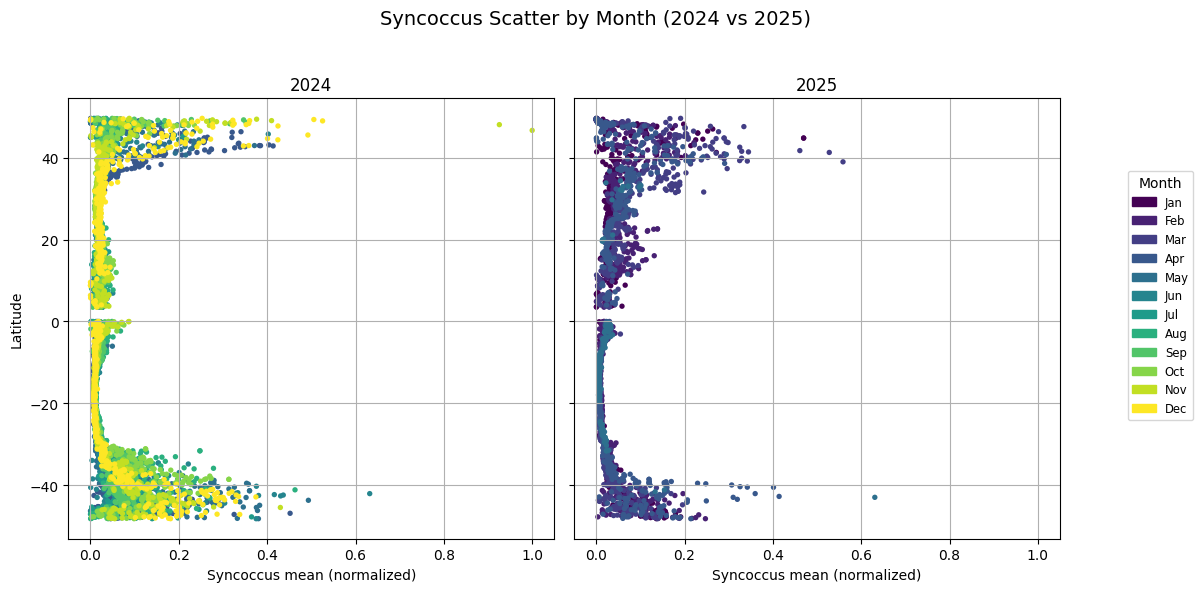

In [69]:
import matplotlib.patches as mpatches

# Prep month columns
df_syn_wide["month_dt"] = pd.to_datetime(df_syn_wide["month_year"], format="%b %Y")
df_syn_wide["year"] = df_syn_wide["month_dt"].dt.year
df_syn_wide["month_name"] = df_syn_wide["month_dt"].dt.strftime("%b")
df_syn_wide["month_num"] = df_syn_wide["month_dt"].dt.month  # for sorting

# Identify months that are actually present, sorted by calendar order
unique_months = (
    df_syn_wide[["month_name", "month_num"]]
    .drop_duplicates()
    .sort_values("month_num")
    .reset_index(drop=True)
)
month_ordered = unique_months["month_name"].tolist()
n_months = len(month_ordered)

# Assign colors in order
colors = cm.viridis(np.linspace(0, 1, n_months))
month_color_map = dict(zip(month_ordered, colors))

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

for ax, year in zip(axes, [2024, 2025]):
    df_year = df_syn_wide[df_syn_wide["year"] == year]
    
    for month in month_ordered:
        df_month = df_year[df_year["month_name"] == month]
        if not df_month.empty:
            ax.scatter(
                df_month["mean"],
                df_month["Lat"],
                color=month_color_map[month],
                s=15,
                edgecolor="none",
                label=month
            )
    
    ax.set_title(f"{year}")
    ax.set_xlabel("Syncoccus mean (normalized)")
    if year == 2024:
        ax.set_ylabel("Latitude")
    ax.grid(True)

# Custom legend with only used months in correct order
legend_patches = [
    mpatches.Patch(color=month_color_map[m], label=m) for m in month_ordered
]
fig.legend(
    handles=legend_patches,
    title="Month",
    loc="center right",
    fontsize="small",
    title_fontsize="medium"
)

# Final layout
fig.suptitle("Syncoccus Scatter by Month (2024 vs 2025)", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


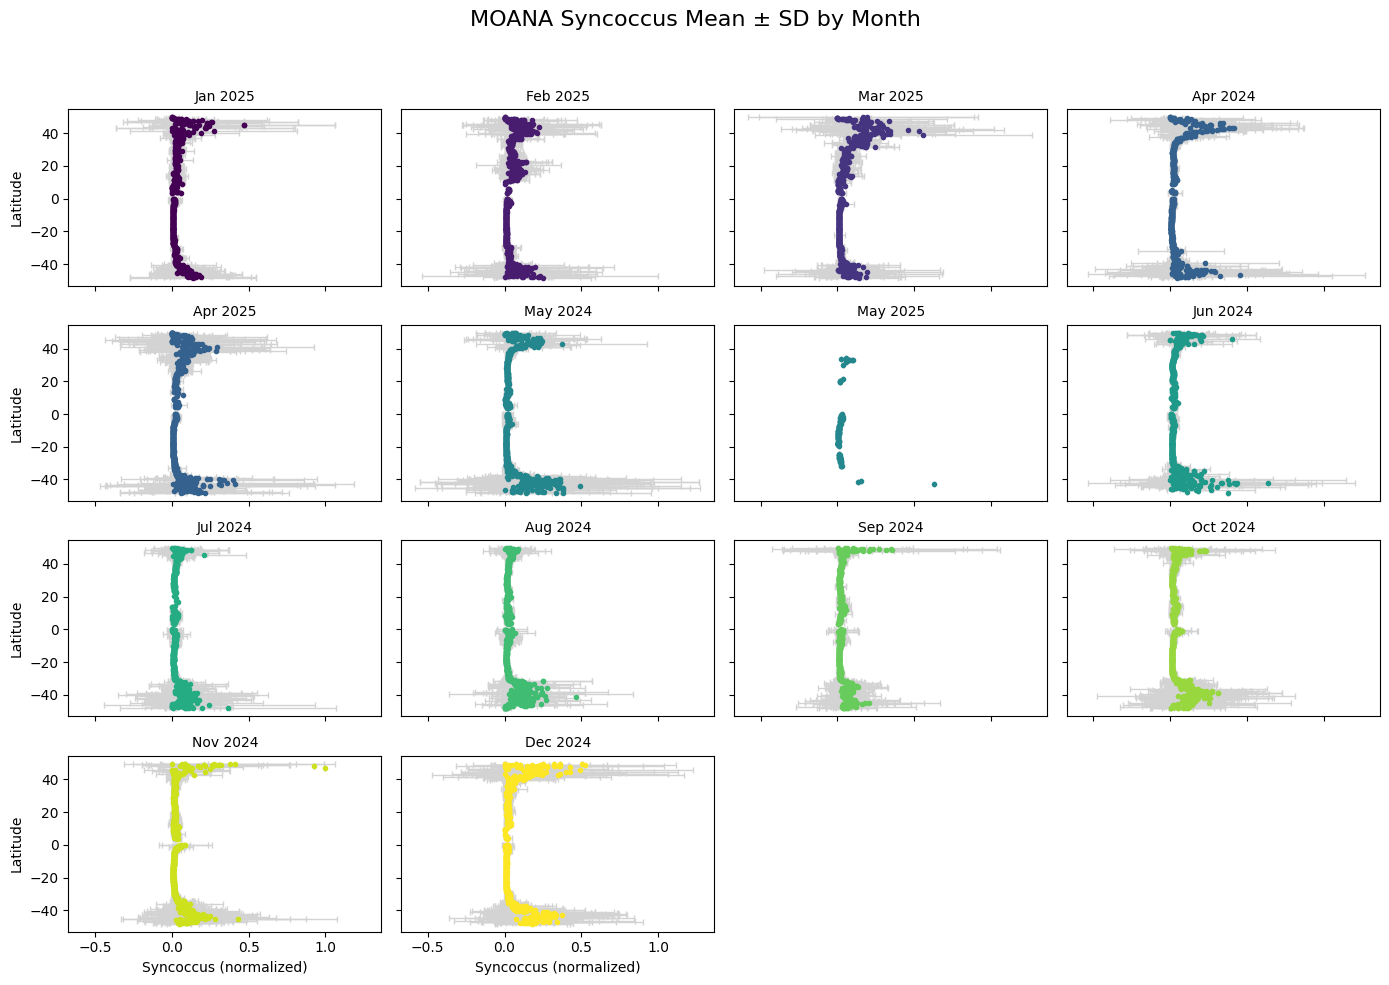

In [70]:
# Prep: extract and sort month names for color consistency
df_syn_wide["month_dt"] = pd.to_datetime(df_syn_wide["month_year"], format="%b %Y")
df_syn_wide["month_name"] = df_syn_wide["month_dt"].dt.strftime("%b")
df_syn_wide["month_num"] = df_syn_wide["month_dt"].dt.month

# Sort months chronologically
months_sorted = (
    df_syn_wide[["month_year", "month_name", "month_num"]]
    .drop_duplicates()
    .sort_values("month_num")
    .reset_index(drop=True)
)
month_ordered = months_sorted["month_name"].tolist()

# Assign a consistent color to each month name
colors = cm.viridis(np.linspace(0, 1, len(month_ordered)))
month_color_map = dict(zip(month_ordered, colors))

# Sorted list of unique month_year labels (for subplot titles)
months = months_sorted["month_year"].tolist()

# Set up facet layout
ncols = 4
nrows = int(np.ceil(len(months) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each month
for i, month in enumerate(months):
    ax = axes[i]
    
    plot_data = df_syn_wide[df_syn_wide["month_year"] == month]
    month_name = plot_data["month_name"].iloc[0]
    color = month_color_map[month_name]
    
    ax.errorbar(
        plot_data["mean"],
        plot_data["Lat"],
        xerr=plot_data["std"],
        fmt="o",
        color=color,
        ecolor="lightgray",
        elinewidth=1,
        capsize=2,
        markersize=3
    )
    
    ax.set_title(month, fontsize=10)
    if i % ncols == 0:
        ax.set_ylabel("Latitude")
    if i >= len(axes) - ncols:
        ax.set_xlabel("Syncoccus (normalized)")

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("MOANA Syncoccus Mean ± SD by Month", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
